In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

from plot import plot_two_figures, plot_confusion_matrix, plot_each_labels, plot_histogram_compare_predict_expect
from tools import get_number_components, extract_features, remove_unclassified_input, shuffle, split_x_train_test     
from gaussian_naive_bayes import GaussianNaiveBayesClassifier

# Loading data & Pre-processing

Loading Indiana and Salinas images and their ground truth

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
# Reshaping the HSI as a 2D matrix
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1]))
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1]))
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [6]:
n_classes_indiana = len(np.unique(indiana_labels)) - 1
n_classes_salinas = len(np.unique(salinas_labels)) - 1

In [7]:
print("Number of labels Indiana: {}".format(n_classes_indiana))
print("Number of labels Salinas: {}".format(n_classes_salinas))

Number of labels Indiana: 16
Number of labels Salinas: 16


In [8]:
indiana_class_names = np.arange(n_classes_indiana).astype(str)
salinas_class_names = np.arange(n_classes_salinas).astype(str)

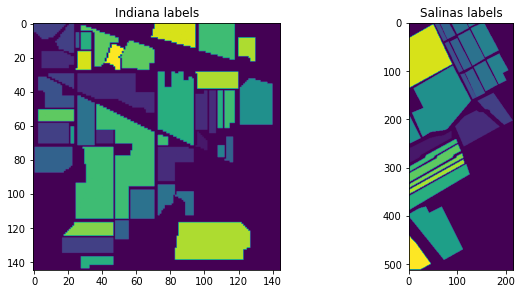

In [9]:
# Display ground truth for each image
plot_two_figures(indiana_labels, salinas_labels, title_fig1='Indiana labels', title_fig2='Salinas labels')

## Remove unclassified data

We will use a supervised learning algorithm. We have to remove data without labels (considered as the background of the ground truth) to allow our model to recognize the different classes. 

In [10]:
X_indiana, X_indiana_idx = remove_unclassified_input(X_indiana, indiana_labels)
X_salinas, X_salinas_idx = remove_unclassified_input(X_salinas, salinas_labels)

In [11]:
indiana_labels_usefull, _ = remove_unclassified_input(indiana_labels.flatten(), indiana_labels)
salinas_labels_usefull, _ = remove_unclassified_input(salinas_labels.flatten(), salinas_labels)

## PCA

PCA stands for principal component analysis. PCA is an unsupervised technique used for reduce the dimensions of the dataset. It transforms the dataset reducing the number of components in order to decrease the computational complexity of the model. 

To reduce the number of component, the PCA computes a linear transformation performing a linear mapping of the data to a lower-dimensional space. It aims to reduce the dimensions with a maximized variance of the data.

In [12]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [13]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 68
Number of components Salinas: 5


After retrieving the optimal number of components for each image, we need to compute a second PCA for each image to extract their features.

In [14]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [15]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (10249, 68)
Salinas reduced data shape: (54129, 5)


## Split data into train / test

We will use a supervised learning algorithm. We need to split our dataset into training and testing dataset. To be sure that our splitting is efficient, we decided to manually split data for each label, it is not possible to use train_test_split.
In addition, we decided to shuffle our data so that the split does not return us the first values of each label in the ground truth. 

We are going to use 75% of the data as the training dataset and 25% for the testing.

In [16]:
# shuffle manually
X_indiana_shuffle, indiana_labels_shuffle, shuffle_arr_indiana = shuffle(X_indiana_reduced, indiana_labels_usefull)
X_salinas_shuffle, salinas_labels_shuffle, shuffle_arr_salinas = shuffle(X_salinas_reduced, salinas_labels_usefull)

In [17]:
y_indiana_labels_argsort = np.argsort(indiana_labels_shuffle)
y_salinas_labels_argsort = np.argsort(salinas_labels_shuffle)

In [18]:
labels_indiana, count_indiana = np.unique(indiana_labels_shuffle-1, return_counts=True)
labels_salinas, count_salinas = np.unique(salinas_labels_shuffle-1, return_counts=True)

In [19]:
x_train_indiana, x_test_indiana, y_train_indiana_labels, y_test_indiana_labels = split_x_train_test(X_indiana_shuffle, count_indiana, labels_indiana, y_indiana_labels_argsort, (0, n_components_indiana))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Nb samples train,34,1071,622,177,362,547,21,358,15,729,1841,444,153,948,289,69
Nb samples test,12,357,208,60,121,183,7,120,5,243,614,149,52,317,97,24
Nb total samples,46,1428,830,237,483,730,28,478,20,972,2455,593,205,1265,386,93


In [20]:
x_train_salinas, x_test_salinas, y_train_salinas_labels, y_test_salinas_labels = split_x_train_test(X_salinas_shuffle, count_salinas, labels_salinas, y_salinas_labels_argsort, (0, n_components_salinas))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Nb samples train,1506,2794,1482,1045,2008,2969,2684,8453,4652,2458,801,1445,687,802,5451,1355
Nb samples test,503,932,494,349,670,990,895,2818,1551,820,267,482,229,268,1817,452
Nb total samples,2009,3726,1976,1394,2678,3959,3579,11271,6203,3278,1068,1927,916,1070,7268,1807


In [21]:
print("Indiana")
print("Train shape: {}".format(x_train_indiana.shape))
print("Train labels shape: {}".format(y_train_indiana_labels.shape))
print("Test shape: {}".format(x_test_indiana.shape))
print("Test labels shape: {}".format(y_test_indiana_labels.shape))
print("----------")
print("Salinas")
print("Train shape: {}".format(x_train_salinas.shape))
print("Train labels shape: {}".format(y_train_salinas_labels.shape))
print("Test shape: {}".format(x_test_salinas.shape))
print("Test labels shape: {}".format(y_test_salinas_labels.shape))

Indiana
Train shape: (7680, 68)
Train labels shape: (7680,)
Test shape: (2569, 68)
Test labels shape: (2569,)
----------
Salinas
Train shape: (40592, 5)
Train labels shape: (40592,)
Test shape: (13537, 5)
Test labels shape: (13537,)


# Gaussian Naive Bayes Classifier

Gaussian Naive Bayes Classifier is a supervised generative model.
The idea is to fit a number of gaussian in a supervised way in the dataset.
In this notebook the covariance matrix for each gaussian is the identity matrix.

In [22]:
nb_classes = np.unique(y_train_indiana_labels).size

In [23]:
n_features_indiana = x_train_indiana.shape[-1]
n_features_salinas = x_train_salinas.shape[-1]

indiana_model_naive_bayes = GaussianNaiveBayesClassifier(nb_gaussian=nb_classes, n_features=n_features_indiana)
salinas_model_naive_bayes = GaussianNaiveBayesClassifier(nb_gaussian=nb_classes, n_features=n_features_salinas)

In [24]:
%%time
indiana_model_naive_bayes.fit(x_train_indiana, y_train_indiana_labels)

Fit Gaussian nb. 0
Fit Gaussian nb. 1
Fit Gaussian nb. 2
Fit Gaussian nb. 3
Fit Gaussian nb. 4
Fit Gaussian nb. 5
Fit Gaussian nb. 6
Fit Gaussian nb. 7
Fit Gaussian nb. 8
Fit Gaussian nb. 9
Fit Gaussian nb. 10
Fit Gaussian nb. 11
Fit Gaussian nb. 12
Fit Gaussian nb. 13
Fit Gaussian nb. 14
Fit Gaussian nb. 15
CPU times: user 3.69 ms, sys: 275 µs, total: 3.96 ms
Wall time: 3.25 ms


In [25]:
%%time
salinas_model_naive_bayes.fit(x_train_salinas, y_train_salinas_labels)

Fit Gaussian nb. 0
Fit Gaussian nb. 1
Fit Gaussian nb. 2
Fit Gaussian nb. 3
Fit Gaussian nb. 4
Fit Gaussian nb. 5
Fit Gaussian nb. 6
Fit Gaussian nb. 7
Fit Gaussian nb. 8
Fit Gaussian nb. 9
Fit Gaussian nb. 10
Fit Gaussian nb. 11
Fit Gaussian nb. 12
Fit Gaussian nb. 13
Fit Gaussian nb. 14
Fit Gaussian nb. 15
CPU times: user 5.91 ms, sys: 0 ns, total: 5.91 ms
Wall time: 5 ms


#### Test the indiana model on training and testing data

In [26]:
def calculate_mean_score(labels, x_labels, y_labels, model):
    score = 0
    
    cols = ['Cluster', 'Nb samples', 'Score']
    df = pd.DataFrame(columns=cols)

    for label in labels:
        print('Class', label, end=' - ')
        idxs = np.argwhere(y_labels == label).flatten()
        preds = model.predict(x_labels[idxs])
        acc = model.measure_accuracy(preds, y_labels[idxs])
        score += acc

        df.loc[label] = [label, y_labels[idxs].size, acc]

    display(df.T)
    
    return score / len(labels)

In [27]:
%%time
indiana_train_mean_score = calculate_mean_score(labels_indiana, x_train_indiana, y_train_indiana_labels, indiana_model_naive_bayes)
print("Mean accuracy per class: {}".format(indiana_train_mean_score))

Class 0 - Class 1 - Class 2 - Class 3 - Class 4 - Class 5 - Class 6 - Class 7 - Class 8 - Class 9 - Class 10 - Class 11 - Class 12 - Class 13 - Class 14 - Class 15 - 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000
Nb samples,34.000000,1071.000000,622.000000,177.000000,362.000000,547.000000,21.000000,358.000000,15.000000,729.000000,1841.000000,444.000000,153.000000,948.000000,289.000000,69.000000
Score,0.882353,0.544351,0.167203,0.152542,0.041436,0.422303,0.904762,0.712291,0.733333,0.323731,0.234112,0.337838,0.947712,0.818565,0.252595,0.971014


Mean accuracy per class: 0.527883936146049
CPU times: user 2min 27s, sys: 5min 50s, total: 8min 18s
Wall time: 1min 4s


In [28]:
%%time
indiana_test_mean_score = calculate_mean_score(labels_indiana, x_test_indiana, y_test_indiana_labels, indiana_model_naive_bayes)
print("Mean accuracy per class: {}".format(indiana_test_mean_score))

Class 0 - Class 1 - Class 2 - Class 3 - Class 4 - Class 5 - Class 6 - Class 7 - Class 8 - Class 9 - Class 10 - Class 11 - Class 12 - Class 13 - Class 14 - Class 15 - 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.0,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000
Nb samples,12.000000,357.000000,208.000000,60.0,121.000000,183.000000,7.0,120.0,5.0,243.000000,614.000000,149.000000,52.000000,317.000000,97.000000,24.000000
Score,0.916667,0.518207,0.163462,0.2,0.024793,0.442623,1.0,0.7,1.0,0.300412,0.245928,0.288591,0.942308,0.835962,0.237113,0.958333


Mean accuracy per class: 0.5483999290954307
CPU times: user 52.5 s, sys: 2min 4s, total: 2min 56s
Wall time: 22.8 s


The scores are around 0.50 which is neither catastrophic nor adequate.

#### Test the salinas model on training and testing data

In [29]:
%%time
salinas_train_mean_score = calculate_mean_score(labels_salinas, x_train_salinas, y_train_salinas_labels, salinas_model_naive_bayes)
print("Mean accuracy per class: {}".format(salinas_train_mean_score))

Class 0 - Class 1 - Class 2 - Class 3 - Class 4 - Class 5 - Class 6 - Class 7 - Class 8 - Class 9 - Class 10 - Class 11 - Class 12 - Class 13 - Class 14 - Class 15 - 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.0000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000
Nb samples,1506.000000,2794.000000,1482.000000,1045.000000,2008.000000,2969.000000,2684.000000,8453.000000,4652.0000,2458.000000,801.000000,1445.000000,687.000000,802.000000,5451.000000,1355.000000
Score,0.984728,0.785612,0.759109,0.989474,0.953187,0.968003,0.985842,0.609724,0.8908,0.233116,0.786517,0.900346,0.983988,0.882793,0.610897,0.519557


Mean accuracy per class: 0.8027308527955032
CPU times: user 33.7 s, sys: 526 ms, total: 34.2 s
Wall time: 33.8 s


In [30]:
%%time
salinas_test_mean_score = calculate_mean_score(labels_salinas, x_test_salinas, y_test_salinas_labels, salinas_model_naive_bayes)
print("Mean accuracy per class: {}".format(salinas_test_mean_score))

Class 0 - Class 1 - Class 2 - Class 3 - Class 4 - Class 5 - Class 6 - Class 7 - Class 8 - Class 9 - Class 10 - Class 11 - Class 12 - Class 13 - Class 14 - Class 15 - 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000
Nb samples,503.000000,932.000000,494.000000,349.000000,670.000000,990.000000,895.000000,2818.000000,1551.000000,820.000000,267.000000,482.000000,229.000000,268.000000,1817.000000,452.000000
Score,0.980119,0.810086,0.759109,0.982808,0.956716,0.964646,0.989944,0.604684,0.897485,0.253659,0.842697,0.910788,0.991266,0.910448,0.603742,0.544248


Mean accuracy per class: 0.8126529402111663
CPU times: user 11.2 s, sys: 130 ms, total: 11.3 s
Wall time: 11.2 s


Salinas' score are pretty good, it reaches 0.80

#### Classification report for Indiana model

In [31]:
%%time
total_preds_indiana = indiana_model_naive_bayes.predict(x_test_indiana)

CPU times: user 47.7 s, sys: 1min 52s, total: 2min 40s
Wall time: 20.4 s


We can display a histogram containing the number of expected and predicted labels. 

Analyzing our results from a histogram only allows us to determine the number of images per class. We therefore lose a certain amount of information, including the differentiation between false positives and false negatives for each class. This method therefore makes it possible to have a global idea of the efficiency of our model but we cannot deduce much information from it.

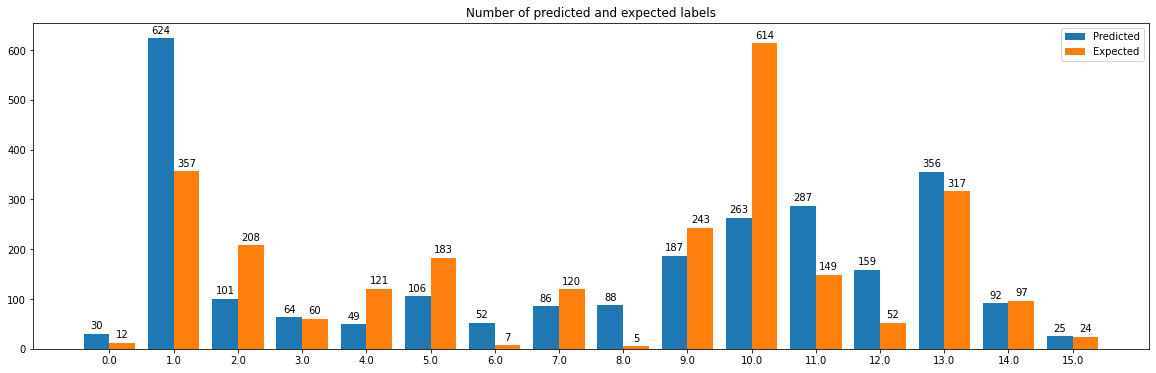

In [32]:
plot_histogram_compare_predict_expect(total_preds_indiana, y_test_indiana_labels)

For most of the classes, our predictions are pretty wrong. For instance, we predicted too much samples for classes 6 and 8 and not enough for class 2.

We will display a confusion matrix.
A confusion matrix is used to highlight false positives and false negatives. The diagonal corresponds to the true positive which makes it possible to visualize more easily the classes having fairly large prediction errors.

By the way, we decided to display this matrix using coloring. This can be done using a linear or logarithmic scale. The logarithmic scale makes it possible to highlight the different variations. 

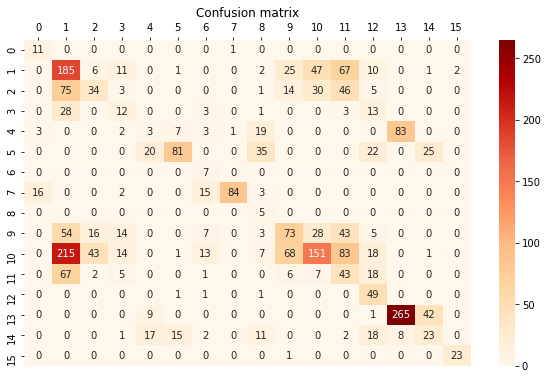

In [33]:
plot_confusion_matrix(y_test_indiana_labels, total_preds_indiana, class_names=indiana_class_names, log=False)

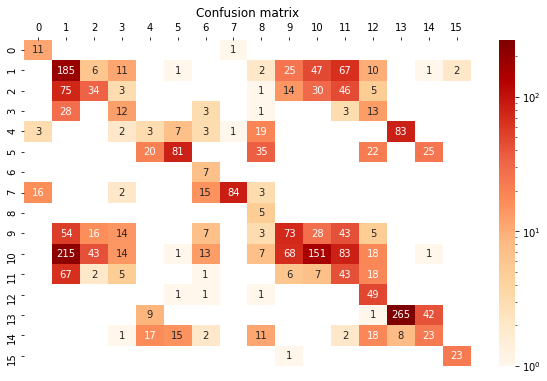

In [34]:
plot_confusion_matrix(y_test_indiana_labels, total_preds_indiana, class_names=indiana_class_names, log=True)

On the confusion matrix, we can see that classify data with label 10 seems difficult to our model. There is a third of the data with label 10 which is classified as label 1 data.

In [35]:
print(classification_report(y_test_indiana_labels, total_preds_indiana, target_names=indiana_class_names))

              precision    recall  f1-score   support

           0       0.37      0.92      0.52        12
           1       0.30      0.52      0.38       357
           2       0.34      0.16      0.22       208
           3       0.19      0.20      0.19        60
           4       0.06      0.02      0.04       121
           5       0.76      0.44      0.56       183
           6       0.13      1.00      0.24         7
           7       0.98      0.70      0.82       120
           8       0.06      1.00      0.11         5
           9       0.39      0.30      0.34       243
          10       0.57      0.25      0.34       614
          11       0.15      0.29      0.20       149
          12       0.31      0.94      0.46        52
          13       0.74      0.84      0.79       317
          14       0.25      0.24      0.24        97
          15       0.92      0.96      0.94        24

    accuracy                           0.41      2569
   macro avg       0.41   

Gaussian Naive Bayes classifier does not look good enough to compute classification on Indiana image. The mean accuracy is only around 0.50. Using the classification report, we can notice that the efficiency of our model is not based on the number of samples per class. For instance, the label 10 contains more than 600 samples but f1-score is only 0.33 whereas label 13 contains 300 samples and its f1-score is 0.80

#### Classification report for Salinas model

In [36]:
%%time
total_preds_salinas = salinas_model_naive_bayes.predict(x_test_salinas)

CPU times: user 11.4 s, sys: 34.1 ms, total: 11.4 s
Wall time: 11.4 s


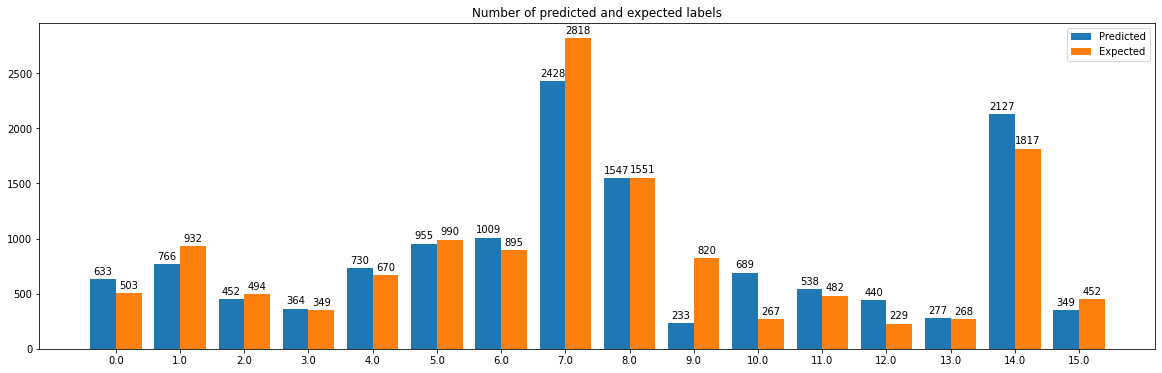

In [37]:
plot_histogram_compare_predict_expect(total_preds_salinas, y_test_salinas_labels)

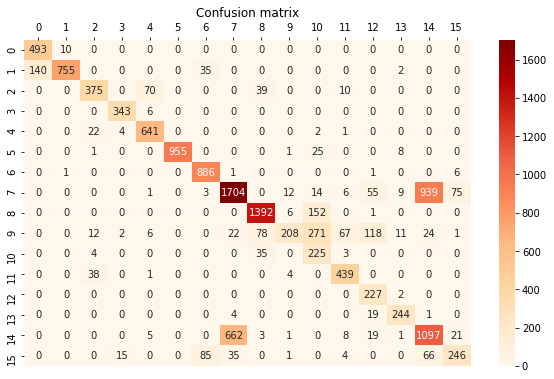

In [38]:
plot_confusion_matrix(y_test_salinas_labels, total_preds_salinas, class_names=salinas_class_names, log=False)

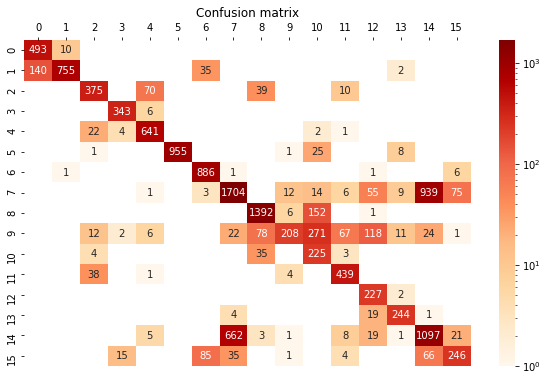

In [39]:
plot_confusion_matrix(y_test_salinas_labels, total_preds_salinas, class_names=salinas_class_names, log=True)

On the confusion matrix, we can easily distinguish the diagonal of the matrix and therefore our model may look efficient in this image. However, we can also see some pretty big errors, especially for classes 7 and 14.

In [40]:
print(classification_report(y_test_salinas_labels, total_preds_salinas, target_names=salinas_class_names))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87       503
           1       0.99      0.81      0.89       932
           2       0.83      0.76      0.79       494
           3       0.94      0.98      0.96       349
           4       0.88      0.96      0.92       670
           5       1.00      0.96      0.98       990
           6       0.88      0.99      0.93       895
           7       0.70      0.60      0.65      2818
           8       0.90      0.90      0.90      1551
           9       0.89      0.25      0.40       820
          10       0.33      0.84      0.47       267
          11       0.82      0.91      0.86       482
          12       0.52      0.99      0.68       229
          13       0.88      0.91      0.90       268
          14       0.52      0.60      0.56      1817
          15       0.70      0.54      0.61       452

    accuracy                           0.76     13537
   macro avg       0.78   

Even if there is a few labels with a f1-score lower than 0.50, we can consider that having a accuracy upper than 0.70 is good enough to perform classifications.

### Prediction on images

#### Indiana image

In [41]:
%%time
total_preds_indiana = indiana_model_naive_bayes.predict(X_indiana_reduced)

CPU times: user 3min 21s, sys: 7min 56s, total: 11min 18s
Wall time: 1min 27s


In [42]:
indiana_preds_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
indiana_preds_img[X_indiana_idx] = total_preds_indiana + 1
indiana_preds_img = indiana_preds_img.reshape(((indiana_img.shape[0], indiana_img.shape[1])))

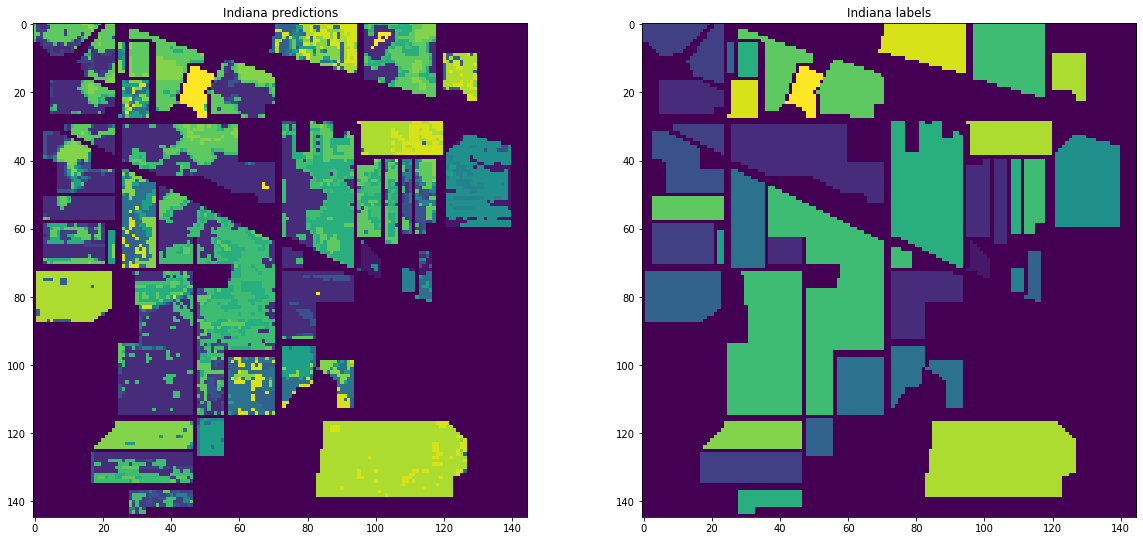

In [43]:
plot_two_figures(indiana_preds_img, indiana_labels, 'Indiana predictions', 'Indiana labels', figsize=(20, 20))

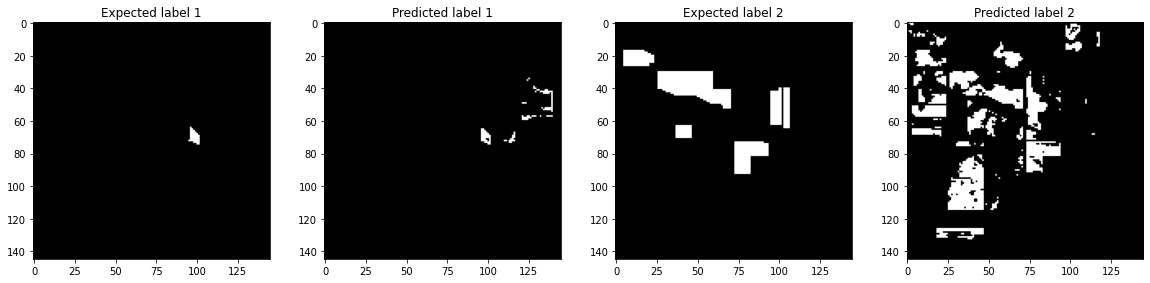

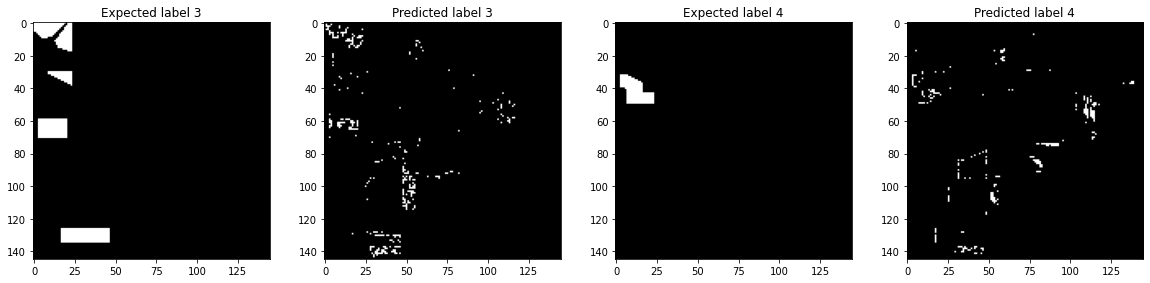

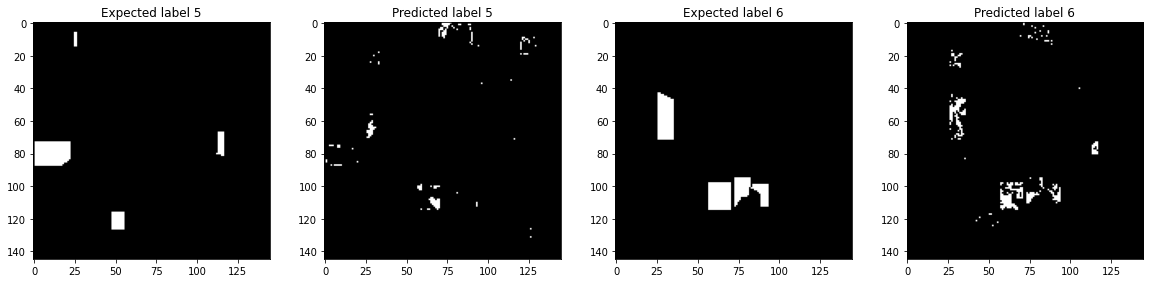

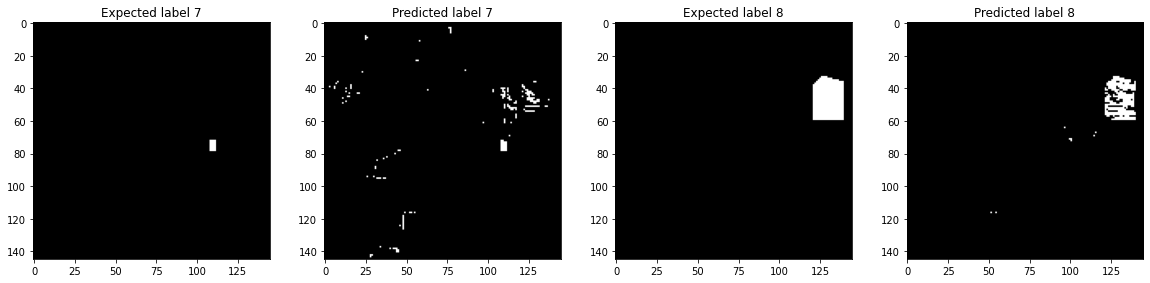

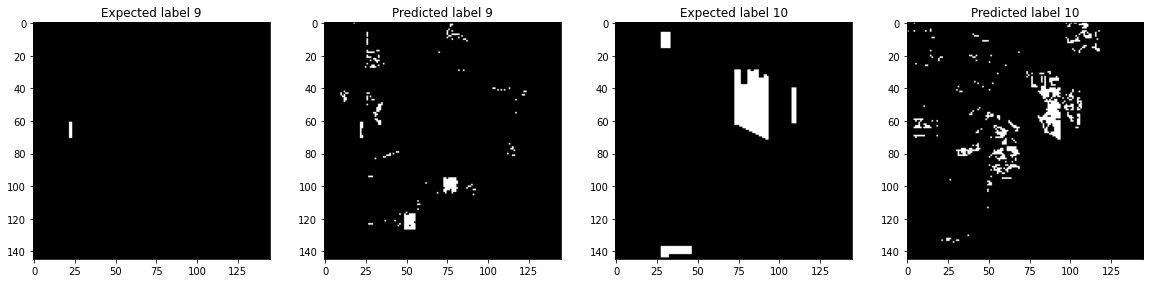

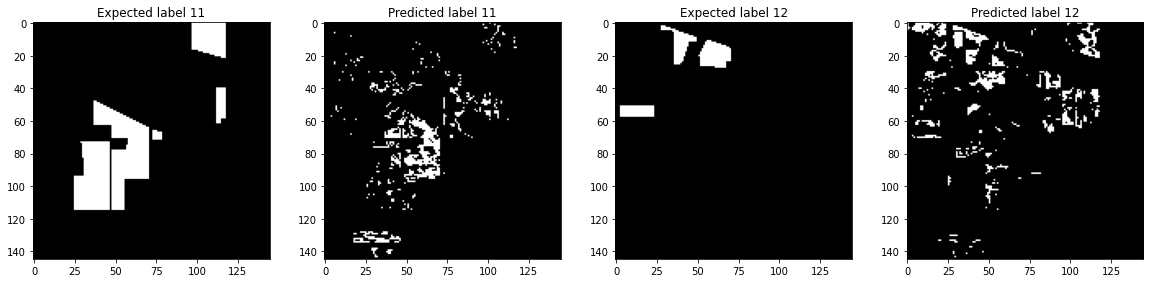

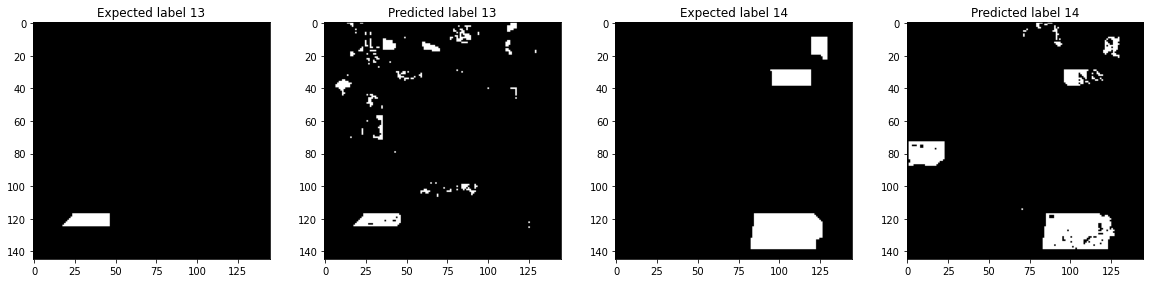

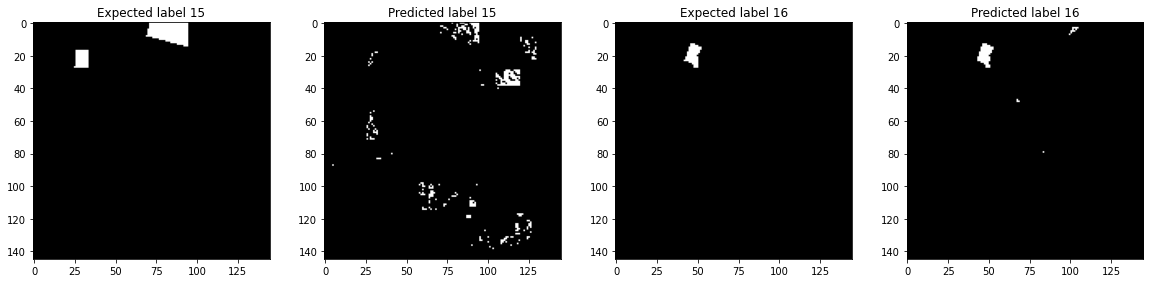

In [44]:
plot_each_labels(indiana_labels, indiana_preds_img, n_classes_indiana, figsize=(20, 20), cmap='gray')

On indiana image, the model had a accuracy of 0.41. When we look at each label, we can notice that some classes have been correctly identified while others are not at all. In addition, there is a lot of noise on each label.

#### Salinas image

In [45]:
%%time
total_preds_salinas = salinas_model_naive_bayes.predict(X_salinas_reduced)

CPU times: user 44.1 s, sys: 108 ms, total: 44.2 s
Wall time: 44.2 s


In [46]:
salinas_preds_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))
salinas_preds_img[X_salinas_idx] = total_preds_salinas + 1
salinas_preds_img = salinas_preds_img.reshape(((salinas_img.shape[0], salinas_img.shape[1])))

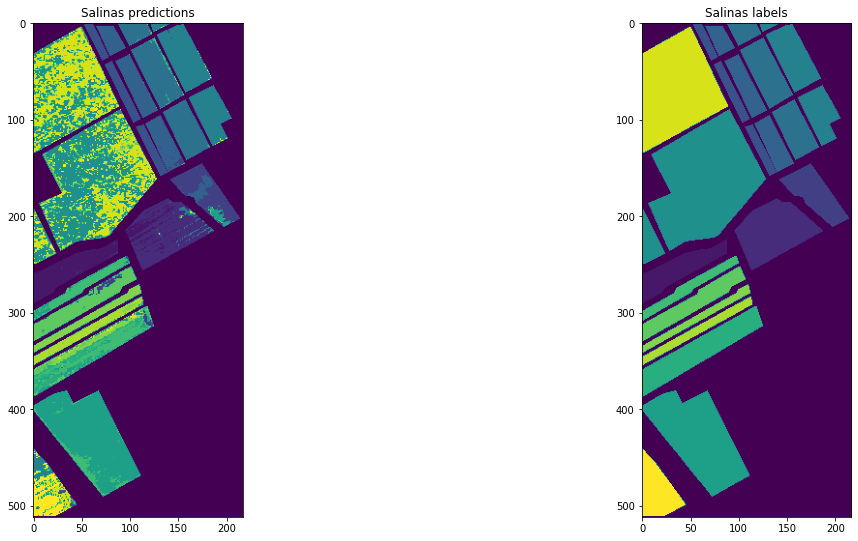

In [47]:
plot_two_figures(salinas_preds_img, salinas_labels, 'Salinas predictions', 'Salinas labels', figsize=(20, 20))

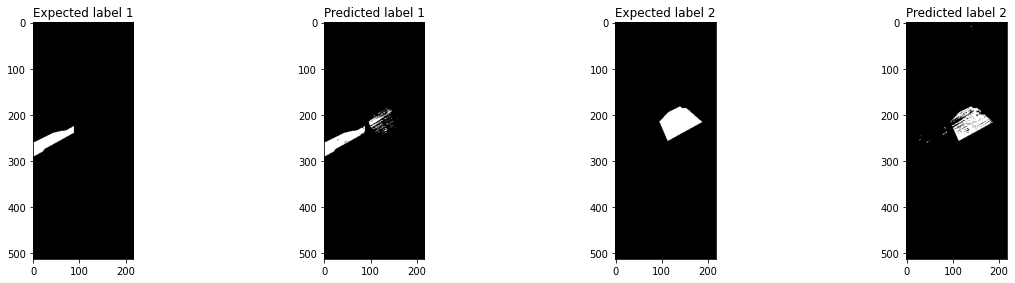

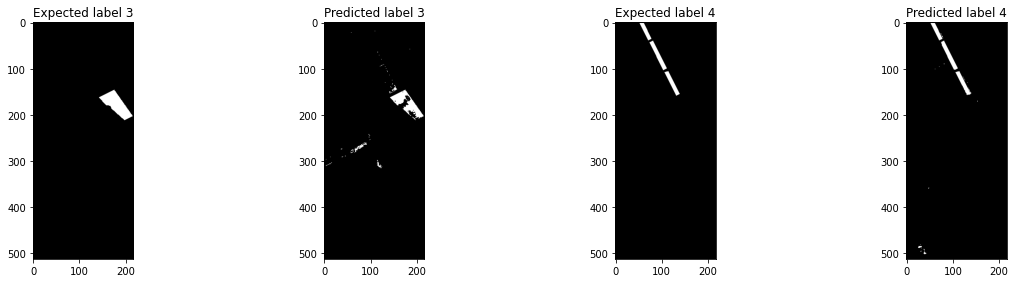

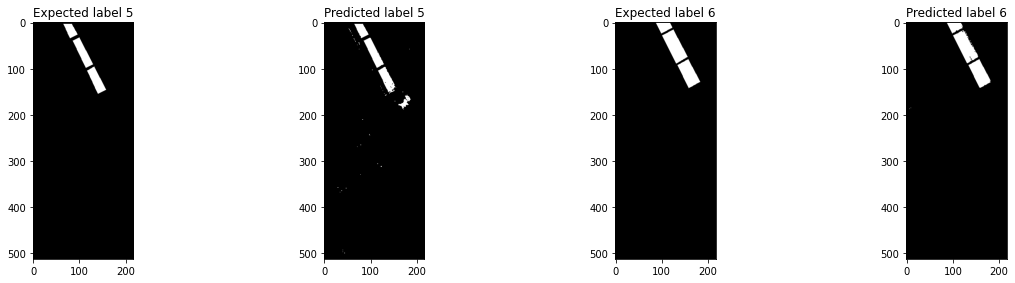

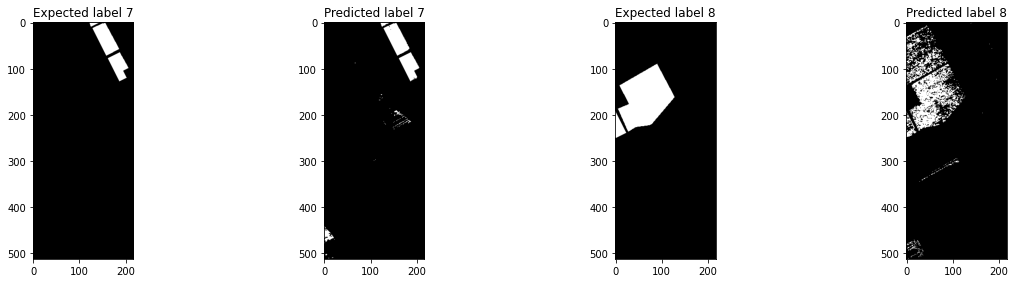

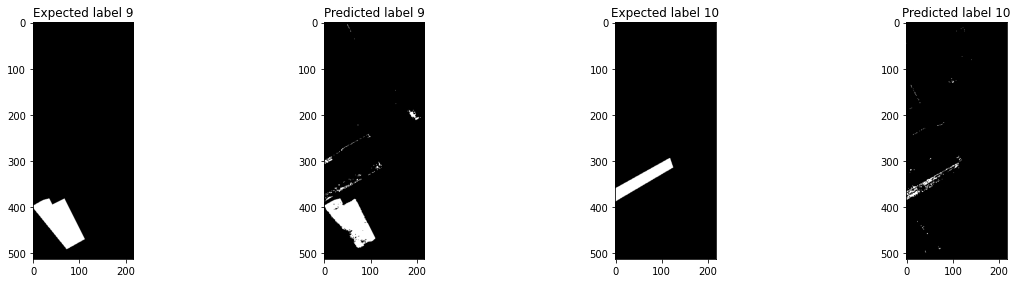

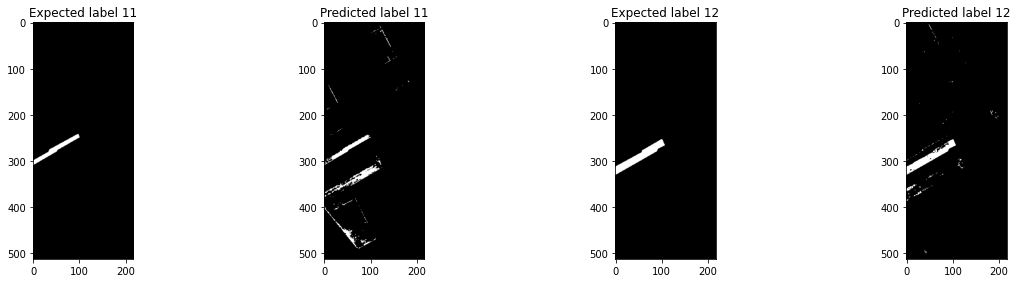

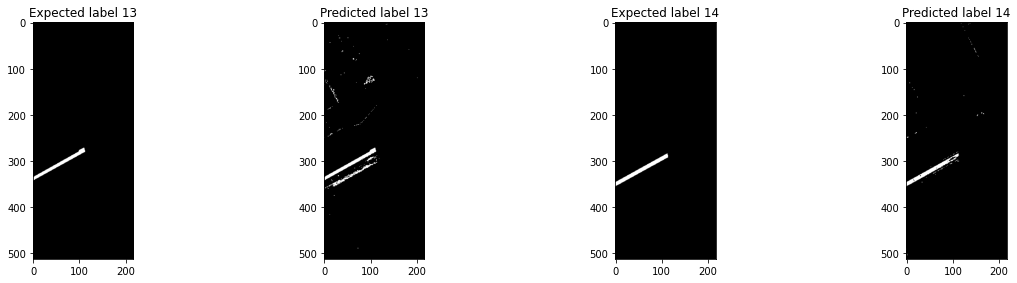

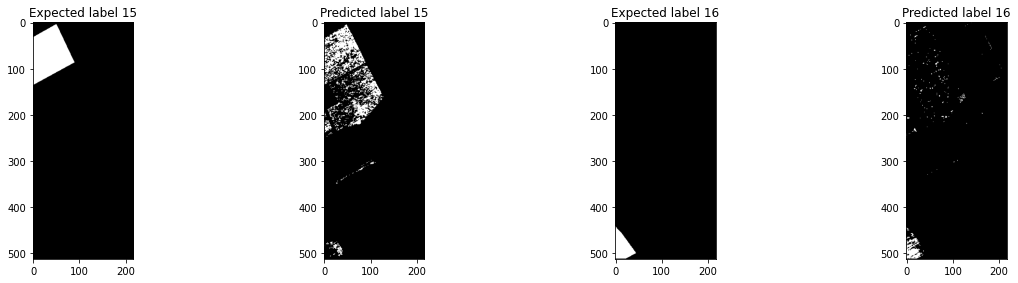

In [48]:
plot_each_labels(salinas_labels, salinas_preds_img, n_classes_salinas, figsize=(20, 20), cmap='gray')

On salinas image, the classification of each label seems appropriate. We can notice that for the labels 8 and 15, there is a lot of noise (those labels are labels 7 and 14 during the training / testing).

## Save predictions

In order to be able to compare models , we save our prediction data on each image. We also save model's score.

In [49]:
np.save('../data/predictions/indiana_preds_gaussianNaiveBayes.npy', indiana_preds_img)
np.save('../data/predictions/salinas_preds_gaussianNaiveBayes.npy', salinas_preds_img)

In [50]:
# Check if csv file exists
try:
    df = pd.read_csv('../data/score.csv')
except Exception:
    cols = ['model', 'image', 'test_score', 'train_score', 'mean_test_score', 'mean_train_score']
    df = pd.DataFrame(columns=cols)

In [51]:
df.loc[df.shape[0]] = ['GaussianNaiveBayes', 'indiana', None, None, indiana_test_mean_score, indiana_train_mean_score]
df.loc[df.shape[0]] = ['GaussianNaiveBayes', 'salinas', None, None, salinas_test_mean_score, salinas_train_mean_score]

In [52]:
df.to_csv('../data/score.csv', index=False)